## Evaluator optimizer workflow works with giving evaluation feedback to improve the content

In [63]:
from typing import TypedDict, Literal, Annotated
from langgraph.graph import START,END,StateGraph
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from IPython.display import Image, display
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
import operator

load_dotenv()

True

In [64]:
generator_llm= ChatOpenAI(model="gpt-4o-mini")
evaluator_llm= ChatOpenAI(model="gpt-5-mini")
optimize_llm= ChatOpenAI(model="gpt-5")

## evaluator using pydantic to enforce the data schema

In [65]:
class Evaluator(BaseModel):
    evaluation: Literal["approved","needs_improvement"] = Field(description="This field is for content evaluation value")
    feedback: str = Field(description="This is a content feedback field")


In [66]:
evaluator_model=evaluator_llm.with_structured_output(Evaluator)

In [67]:
class Content(TypedDict):
    topic: str
    topic_content: str
    evaluation: str
    feedback: str
    numberoflines: int
    iteration: int
    max_iteration: int

    content_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]
    evaluation_history: Annotated[list[str], operator.add]

## Generate content definition

In [68]:
def generate_content(state:Content) -> Content:
    prompt_template=f"""You are an AI content generator about the topic give by the user. \n
    Please help in generating the content for the topic in {state['numberoflines']} lines: \n {state['topic']} """

    generator_response=generator_llm.invoke(prompt_template)
    
    return {"topic_content":generator_response.content,'content_history': [generator_response]}
    

## content evaluator definition

In [69]:
def evaluate_content(state:Content) -> Content:

    prompt_template=f"""You are an AI content evaluator about the content give by the user.\n
    Please help in evaluating the content and provide the short feedback and evaluation: \n {state['topic_content']}"""

    evaluator_response=evaluator_model.invoke(prompt_template)

    return {"evaluation":evaluator_response.evaluation, "feedback":evaluator_response.feedback,"feedback_history":[evaluator_response.feedback],"evaluation_history":[evaluator_response.evaluation]}
    

## Optimizer helps in optimizing the generated content, definition as below

In [70]:
def optimize_content(state:Content) -> Content:

    prompt_template= f"""
You are an AI content optimizer. Your role is to optimize the given content by the user.\n
Please help in optimizing the content from the user and keep it great: \n {state['topic_content']}
"""
    
    optimize_response=optimize_llm.invoke(prompt_template)
    iteration = state['iteration'] + 1

    return {"topic_content":optimize_response,"iteration":iteration, "content_history":[optimize_response]}
    

In [71]:
def evaluation_feedback(state:Content)-> Literal["approved","optimze"]:
    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'
        

    

In [72]:
graph=StateGraph(Content)

In [73]:
graph.add_node("generate_content",generate_content)
graph.add_node("evaluate_content",evaluate_content)
graph.add_node("optimize_content",optimize_content)

graph.add_edge(START,"generate_content")
graph.add_edge("generate_content","evaluate_content")
graph.add_conditional_edges('evaluate_content', evaluation_feedback, {'approved': END, 'needs_improvement': 'optimize_content'})
graph.add_edge("optimize_content","evaluate_content")

In [74]:
workflow=graph.compile()

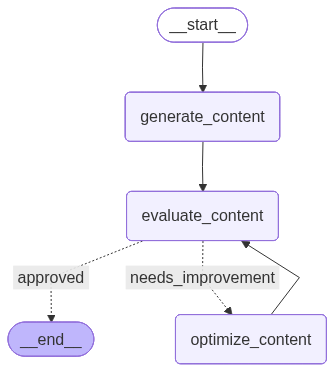

In [75]:
display(Image(workflow.get_graph().draw_mermaid_png()))

In [76]:
initial_state = {
    "topic": "AI rise in India",
    "iteration": 1,
    "max_iteration": 5,
    "numberoflines":10
}
result = workflow.invoke(initial_state)

In [77]:
result

{'topic': 'AI rise in India',
 'topic_content': AIMessage(content='Here are three optimized versions you can choose from, depending on your use case:\n\n1) Polished narrative (full version)\nIndia’s AI momentum is accelerating, powered by advancing technology, rising investment, and a deep pool of tech talent. With strong IT infrastructure and a mature services ecosystem, the country is rapidly emerging as a global hub for AI research, engineering, and deployment. AI-first startups are driving innovation across healthcare, agriculture, finance, and more, while government initiatives—such as the National AI Strategy—promote research and embed AI in public services. Universities are updating curricula to prepare graduates for an AI-driven economy, and multinationals are expanding research centers that strengthen industry–academia collaboration. AI is also addressing societal priorities, from fortifying public health systems to improving citizen services. Challenges around data privacy an